# Reinforcement Learning

This Jupyter notebook acts as supporting material for **Chapter 21 Reinforcement Learning** of the book* Artificial Intelligence: A Modern Approach*. This notebook makes use of the implementations in `rl.py` module. We also make use of implementation of MDPs in the `mdp.py` module to test our agents. It might be helpful if you have already gone through the Jupyter notebook dealing with Markov decision process. Let us import everything from the `rl` module. It might be helpful to view the source of some of our implementations. Please refer to the Introductory Jupyter notebook for more details.

In [1]:
from rl import *

## CONTENTS

* Overview
* Passive Reinforcement Learning
    - Direct Utility Estimation
    - Adaptive Dynamic Programming
    - Temporal-Difference Agent
* Active Reinforcement Learning
    - Q learning

## OVERVIEW

Before we start playing with the actual implementations let us review a couple of things about RL.

1. Reinforcement Learning is concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. 

2. Reinforcement learning differs from standard supervised learning in that correct input/output pairs are never presented, nor sub-optimal actions explicitly corrected. Further, there is a focus on on-line performance, which involves finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

-- Source: [Wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)

In summary we have a sequence of state action transitions with rewards associated with some states. Our goal is to find the optimal policy $\pi$ which tells us what action to take in each state.

## PASSIVE REINFORCEMENT LEARNING

In passive Reinforcement Learning the agent follows a fixed policy $\pi$. Passive learning attempts to evaluate the given policy $pi$ - without any knowledge of the Reward function $R(s)$ and the Transition model $P(s'\ |\ s, a)$.

This is usually done by some method of **utility estimation**. The agent attempts to directly learn the utility of each state that would result from following the policy. Note that at each step, it has to *perceive* the reward and the state - it has no global knowledge of these. Thus, if a certain the entire set of actions offers a very low probability of attaining some state $s_+$ - the agent may never perceive the reward $R(s_+)$.

Consider a situation where an agent is given a policy to follow. Thus, at any point it knows only its current state and current reward, and the action it must take next. This action may lead it to more than one state, with different probabilities.

For a series of actions given by $\pi$, the estimated utility $U$:
$$U^{\pi}(s) = E(\sum_{t=0}^\inf \gamma^t R^t(s')$$)
Or the expected value of summed discounted rewards until termination.

Based on this concept, we discuss three methods of estimating utility:

1. **Direct Utility Estimation (DUE)**
 
 The first, most naive method of estimating utility comes from the simplest interpretation of the above definition. We construct an agent that follows the policy until it reaches the terminal state. At each step, it logs its current state, reward. Once it reaches the terminal state, it can estimate the utility for each state for *that* iteration, by simply summing the discounted rewards from that state to the terminal one.

 It can now run this 'simulation' $n$ times, and calculate the average utility of each state. If a state occurs more than once in a simulation, both its utility values are counted separately.
 
 Note that this method may be prohibitively slow for very large statespaces. Besides, **it pays no attention to the transition probability $P(s'\ |\ s, a)$.** It misses out on information that it is capable of collecting (say, by recording the number of times an action from one state led to another state). The next method addresses this issue.
 
2. **Adaptive Dynamic Programming (ADP)**
 
 This method makes use of knowledge of the past state $s$, the action $a$, and the new perceived state $s'$ to estimate the transition probability $P(s'\ |\ s,a)$. It does this by the simple counting of new states resulting from previous states and actions.<br> 
 The program runs through the policy a number of times, keeping track of:
    - each occurrence of state $s$ and the policy-recommended action $a$ in $N_{sa}$
    - each occurrence of $s'$ resulting from $a$ on $s$ in $N_{s'|sa}$.
     
 It can thus estimate $P(s'\ |\ s,a)$ as $N_{s'|sa}/N_{sa}$, which in the limit of infinite trials, will converge to the true value.<br>
 Using the transition probabilities thus estimated, it can apply `POLICY-EVALUATION` to estimate the utilities $U(s)$ using properties of convergence of the Bellman functions.

3. **Temporal-difference learning (TD)**
 
 Instead of explicitly building the transition model $P$, the temporal-difference model makes use of the expected closeness between the utilities of two consecutive states $s$ and $s'$.
 For the transition $s$ to $s'$, the update is written as:
$$U^{\pi}(s) \leftarrow U^{\pi}(s) + \alpha \left( R(s) + \gamma U^{\pi}(s') - U^{\pi}(s) \right)$$
 This model implicitly incorporates the transition probabilities by being weighed for each state by the number of times it is achieved from the current state. Thus, over a number of iterations, it converges similarly to the Bellman equations.
 The advantage of the TD learning model is its relatively simple computation at each step, rather than having to keep track of various counts.
 For $n_s$ states and $n_a$ actions the ADP model would have $n_s \times n_a$ numbers $N_{sa}$ and $n_s^2 \times n_a$ numbers $N_{s'|sa}$ to keep track of. The TD model must only keep track of a utility $U(s)$ for each state.

#### Demonstrating Passive agents

Passive agents are implemented in `rl.py` as various `Agent-Class`es.

To demonstrate these agents, we make use of the `GridMDP` object from the `MDP` module. `sequential_decision_environment` is similar to that used for the `MDP` notebook but has discounting with $\gamma = 0.9$.

The `Agent-Program` can be obtained by creating an instance of the relevant `Agent-Class`. The `__call__` method allows the `Agent-Class` to be called as a function. The class needs to be instantiated with a policy ($\pi$) and an `MDP` whose utility of states will be estimated.

In [2]:
# ML: Originally sequential_decision_environment was imported directly from mdp.py . 
# I'm modifying the discount factor, however, to match the values from the experiments 
# in the book.
from mdp import GridMDP
sequential_decision_environment = GridMDP([[-0.04, -0.04, -0.04, +1],
                                           [-0.04, None, -0.04, -1],
                                           [-0.04, -0.04, -0.04, -0.04]],
                                          terminals=[(3, 2), (3, 1)],gamma=1.0)

The `sequential_decision_environment` is a GridMDP object as shown below. The rewards are **+1** and **-1** in the terminal states, and **-0.04** in the rest. <img src="files/images/mdp.png"> Now we define actions and a policy similar to **Fig 21.1** in the book.

In [126]:
# Action Directions
north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

policy = {
    (0, 2): east,  (1, 2): east,  (2, 2): east,   (3, 2): None,
    (0, 1): north,                (2, 1): north,  (3, 1): None,
    (0, 0): north, (1, 0): west,  (2, 0): west,   (3, 0): west, 
}


###  Direction Utility Estimation Agent

The `PassiveDEUAgent` class in the `rl` module implements the Agent Program described in **Fig 21.2** of the AIMA Book. `PassiveDEUAgent` sums over rewards to find the estimated utility for each state. It thus requires the running of a number of iterations.

In [4]:
%psource PassiveDUEAgent

In [5]:
DUEagent = PassiveDUEAgent(policy, sequential_decision_environment)
for i in range(200):
    run_single_trial(DUEagent, sequential_decision_environment)
    DUEagent.estimate_U()



The calculated utilities are:

In [6]:
print('\n'.join([str(k)+':'+str(v) for k, v in DUEagent.U.items()]))

(0, 1):0.7655623897642863
(1, 2):0.8971442886814158
(3, 2):1.0
(0, 0):0.6709442737692293
(2, 2):0.954983596783114
(0, 2):0.8026156545940505
(2, 1):0.8477274831136068
(1, 0):0.5760885198016962
(3, 1):-1.0


### Adaptive Dynamic Programming Agent

The `PassiveADPAgent` class in the `rl` module implements the Agent Program described in **Fig 21.2** of the AIMA Book. `PassiveADPAgent` uses state transition and occurrence counts to estimate $P$, and then $U$. Go through the source below to understand the agent.

In [7]:
%psource PassiveADPAgent

We instantiate a `PassiveADPAgent` below with the `GridMDP` shown and train it over 200 iterations. The `rl` module has a simple implementation to simulate iterations. The function is called **run_single_trial**.

In [8]:
ADPagent = PassiveADPAgent(policy, sequential_decision_environment)
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment)

The calculated utilities are:

In [9]:
print('\n'.join([str(k)+':'+str(v) for k, v in ADPagent.U.items()]))

(0, 0):0.7045999999823791
(0, 1):0.7611999999980448
(1, 2):0.8667999999999739
(3, 2):1.0
(3, 0):0.0
(3, 1):-1.0
(2, 1):0.6352479999999716
(2, 0):0.0
(2, 2):0.9145999999999956
(1, 0):0.6517999999596297
(0, 2):0.8109345132740278


### Passive Temporal Difference Agent

`PassiveTDAgent` uses temporal differences to learn utility estimates. We learn the difference between the states and backup the values to previous states.  Let us look into the source before we see some usage examples.

In [10]:
%psource PassiveTDAgent

In creating the `TDAgent`, we use the **same learning rate** $\alpha$ as given in the footnote of the book on **page 837**.

In [11]:
TDagent = PassiveTDAgent(policy, sequential_decision_environment, alpha = lambda n: 60./(59+n))

Now we run **200 trials** for the agent to estimate Utilities.

In [12]:
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment)

The calculated utilities are:

In [13]:
print('\n'.join([str(k)+':'+str(v) for k, v in TDagent.U.items()]))

(0, 1):0.7832538860929997
(1, 2):0.893033577768742
(3, 2):1
(0, 0):0.7416651617972625
(3, 0):0.0
(3, 1):0.0
(2, 1):0.8851106822584278
(2, 0):0.0
(2, 2):0.9500920126151944
(1, 0):0.6442156164250886
(0, 2):0.8294430193978128


## Comparison with value iteration method

We can also compare the utility estimates learned by our agent to those obtained via **value iteration**.

**Note that value iteration has a priori knowledge of the transition table $P$, the rewards $R$, and all the states $s$.**

In [14]:
from mdp import value_iteration, policy_iteration, policy_evaluation

The values calculated by value iteration:

In [15]:
U_values = value_iteration(sequential_decision_environment)
print('\n'.join([str(k)+':'+str(v) for k, v in U_values.items()]))

(0, 1):0.7615582191780823
(1, 2):0.8678082191780823
(3, 2):1.0
(0, 0):0.7053082191780823
(3, 0):0.3879249112125825
(3, 1):-1.0
(2, 1):0.6602739726027398
(2, 0):0.6114155251141552
(2, 2):0.9178082191780822
(1, 0):0.6553082191780822
(0, 2):0.8115582191780822


Let's try policy iteration as well

In [16]:
U = {s: 0 for s in sequential_decision_environment.states}

pi = policy_iteration(sequential_decision_environment)
U_values = policy_evaluation(pi, U, sequential_decision_environment)
print('\n'.join([str(k)+':'+str(v) for k, v in U_values.items()]))

(0, 1):0.7615582131239454
(1, 2):0.8678082191733488
(3, 2):1.0
(0, 0):0.7053081826495631
(3, 0):0.38792413714765106
(3, 1):-1.0
(2, 1):0.6602739726014015
(2, 0):0.611415289410149
(2, 2):0.9178082191778514
(1, 0):0.6553081482252293
(0, 2):0.8115582182883859


In [64]:
from utils import print_table
print_table(sequential_decision_environment.to_arrows(pi))

>   >      >   .
^   None   ^   .
^   <      <   <


## Evolution of utility estimates over iterations

We can explore how these estimates vary with time by using plots similar to **Fig 21.5a**. We will first enable matplotlib using the inline backend. We also define a function to collect the values of utilities at each iteration.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def graph_utility_estimates(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        for state in states_to_graph:
            graphs[state].append((iteration, agent_program.U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

Here is a plot of state $(2,2)$.

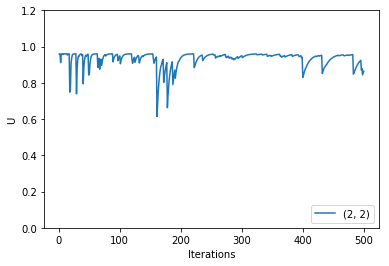

In [18]:
agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])

It is also possible to plot multiple states on the same plot. As expected, the utility of the finite state $(3,2)$ stays constant and is equal to $R((3,2)) = 1$.

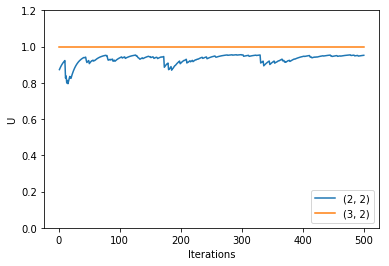

In [19]:
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2), (3,2)])

## ACTIVE REINFORCEMENT LEARNING

Unlike Passive Reinforcement Learning in Active Reinforcement Learning we are not bound by a policy pi and we need to select our actions. In other words the agent needs to learn an optimal policy. The fundamental tradeoff the agent needs to face is that of exploration vs. exploitation. 

### QLearning Agent

The QLearningAgent class in the rl module implements the Agent Program described in **Fig 21.8** of the AIMA Book. In Q-Learning the agent learns an action-value function Q which gives the utility of taking a given action in a particular state. Q-Learning does not required a transition model and hence is a model free method. Let us look into the source before we see some usage examples.

In [20]:
%psource QLearningAgent

The Agent Program can be obtained by creating the instance of the class by passing the appropriate parameters. Because of the __ call __ method the object that is created behaves like a callable and returns an appropriate action as most Agent Programs do. To instantiate the object we need a mdp similar to the PassiveTDAgent.

 Let us use the same GridMDP object we used above. **Figure 17.1 (sequential_decision_environment)** is similar to **Figure 21.1** but has some discounting as **gamma = 0.9**. The class also implements an exploration function **f** which returns fixed **Rplus** until agent has visited state, action **Ne** number of times. This is the same as the one defined on page **842** of the book. The method **actions_in_state** returns actions possible in given state. It is useful when applying max and argmax operations.

Let us create our object now. We also use the **same alpha** as given in the footnote of the book on **page 837**. We use **Rplus = 2** and **Ne = 5** as defined on page 843. **Fig 21.7**  

In [21]:
q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=2, 
                         alpha=lambda n: 60./(59+n))

Now to try out the q_agent we make use of the **run_single_trial** function in rl.py (which was also used above). Let us use **200** iterations.

In [22]:
for i in range(200):
    run_single_trial(q_agent,sequential_decision_environment)

Now let us see the Q Values. The keys are state-action pairs. Where different actions correspond according to:

north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

In [23]:
q_agent.Q

defaultdict(float,
            {((0, 0), (1, 0)): -0.10769632032359491,
             ((0, 0), (0, 1)): 0.4974200644430532,
             ((0, 0), (-1, 0)): -0.1132867132867133,
             ((0, 0), (0, -1)): -0.07999993704515122,
             ((1, 0), (1, 0)): -0.14589762186509908,
             ((1, 0), (0, 1)): -0.14910760880910137,
             ((1, 0), (-1, 0)): 0.47722184796096634,
             ((1, 0), (0, -1)): -0.11692301396822814,
             ((2, 0), (1, 0)): -0.04,
             ((2, 0), (0, 1)): 0.4926769340179932,
             ((2, 0), (-1, 0)): 0.5258120754543356,
             ((2, 0), (0, -1)): 0.05754346548918443,
             ((3, 0), (1, 0)): -0.9775,
             ((3, 0), (0, 1)): -0.9592478257833501,
             ((3, 0), (-1, 0)): 0.7093979111285913,
             ((3, 0), (0, -1)): 0.0,
             ((3, 1), None): -0.38736979950114425,
             ((0, 1), (1, 0)): -0.07692307692307693,
             ((0, 1), (0, 1)): 0.5566088612206392,
             ((0, 1), (-1, 

The Utility **U** of each state is related to **Q** by the following equation.

**U (s) = max <sub>a</sub> Q(s, a)**

Let us convert the Q Values above into U estimates.



In [24]:
U = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison see below.
for state_action, value in q_agent.Q.items():
    state, action = state_action
    if U[state] < value:
                U[state] = value

In [25]:
U

defaultdict(<function __main__.<lambda>()>,
            {(0, 0): 0.4974200644430532,
             (1, 0): 0.47722184796096634,
             (2, 0): 0.5258120754543356,
             (3, 0): 0.7093979111285913,
             (3, 1): -0.38736979950114425,
             (0, 1): 0.5566088612206392,
             (0, 2): 0.6131414683403421,
             (1, 2): 0.5783369008186893,
             (2, 2): 0.5780807620865042,
             (3, 2): 0.5875183936502257,
             (2, 1): 0.6004361367638577})

Let us finally compare these estimates to value_iteration results.

In [26]:
print(value_iteration(sequential_decision_environment))

{(0, 1): 0.7615582191780823, (1, 2): 0.8678082191780823, (3, 2): 1.0, (0, 0): 0.7053082191780823, (3, 0): 0.3879249112125825, (3, 1): -1.0, (2, 1): 0.6602739726027398, (2, 0): 0.6114155251141552, (2, 2): 0.9178082191780822, (1, 0): 0.6553082191780822, (0, 2): 0.8115582191780822}


### Exercises

**21.1** Implement a passive learning agent in a simple environment, such as the 4×3 world. For the case of an initially unknown environment model, compare the learning performance of the direct utility estimation, TD, and ADP algorithms. Do the comparison for the optimal policy and for several random policies. For which do the utility estimates converge faster? What happens when the size of the environment is increased? (Try environments with and without obstacles.)

In [79]:
# Adding a reset function to each agent
class PassiveDUEAgentM(PassiveDUEAgent):
    def reset(self):
        self.U = {s: 0. for s in self.mdp.states}
        self.s = None
        self.a = None
        self.s_history = []
        self.r_history = []
        
class PassiveADPAgentM(PassiveADPAgent):
    def reset(self):
        nested_dict = lambda: defaultdict(nested_dict)
        self.mdp.P = nested_dict()
        self.U = {s: 0. for s in self.mdp.states}
        self.Nsa = defaultdict(int)
        self.Ns1_sa = defaultdict(int)
        self.s = None
        self.a = None
        self.visited = set()        # keeping track of visited states
        
class PassiveTDAgentM(PassiveTDAgent):
    def __init__(self, pi, mdp, alpha=None):
        self.mdp = mdp
        super(PassiveTDAgentM,self).__init__(pi, mdp, alpha)
    
    def reset(self):
        self.U = {s: 0. for s in self.mdp.states}
        self.Ns = {s: 0 for s in self.mdp.states}
        self.s = None
        self.a = None
        self.r = None

In [185]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def graph_utility_rms_policy_loss(agent_program, mdp, policy, trials, runs):
    '''
    Graph RMS of utilities and an associated policy loss
    '''
    # find optimal U; we can do that since we know everything about MDP, but later we assume that the agent doesn't
    U = {s: 0. for s in mdp.states}
    U = policy_evaluation(policy,U,mdp,500) # for some policies we need to run policy evaluation longer than others
    
    u_rms = np.zeros(trials)
    for run in range(runs):
        u_rms_iter = []
        agent_program.reset()
        for iteration in range(trials):
            run_single_trial(agent_program, mdp)
            if hasattr(agent_program,'estimate_U'):
                agent.estimate_U()
            u_rms_iter.append(np.sqrt(np.mean([(agent_program.U[state]-U[state])**2 for state in U.keys()]))) # calculate RMS of utilities
        u_rms += np.array(u_rms_iter)
    u_rms /= runs # get the average of runs
    x,y = zip(*enumerate(u_rms))
    plt.plot(x,y)
    plt.xlabel('Number of trials')
    plt.ylabel('RMS error in utility')

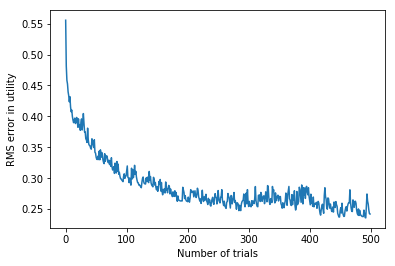

In [132]:
agent = PassiveDUEAgentM(policy, sequential_decision_environment)
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 50)

In [133]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):0.8049274599574667
(1, 2):0.9059291815751931
(3, 2):1.0
(0, 0):0.7516706671792002
(3, 0):0.0
(3, 1):-0.96875
(2, 1):0.9185213288472005
(2, 0):0.0
(2, 2):0.9542187499999999
(1, 0):0.7403470755746298
(0, 2):0.8605288600814671


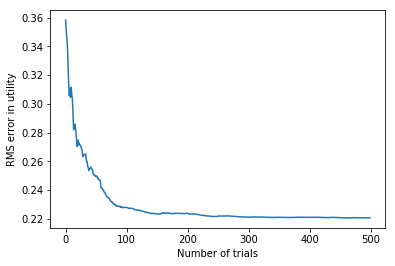

In [135]:
agent = PassiveADPAgentM(policy, sequential_decision_environment)
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 5)

In [136]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):0.7707199999993319
(1, 2):0.8787999999999995
(3, 2):1.0
(0, 0):0.7173599999983736
(3, 0):0.0
(3, 1):-1.0
(2, 1):0.7390523076923076
(2, 0):0.0
(2, 2):0.9306399999999999
(1, 0):0.6705675471673405
(0, 2):0.8200094280761412


Adaptive Dynamic Programming estimates U through policy evaluation. Keep in mind that policy is a discrete function. When steps are observed in the learning curve, it usually means that a better policy was found. 

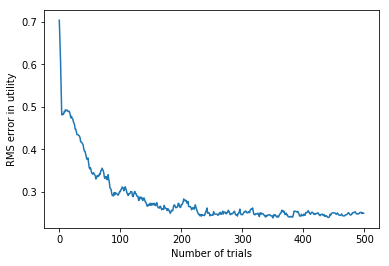

In [137]:
agent = PassiveTDAgentM(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 5)

Now let's repeat this experiment for 2 random policies:

In [186]:
from utils import print_table
np.random.seed(15)
actions = [north,east,south,west]
policy = {s: actions[np.random.choice(4)] for s in sequential_decision_environment.states}
policy[(3,1)] = None
policy[(3,2)] = None
print_table(sequential_decision_environment.to_arrows(policy))

>   >      <   .
^   None   ^   .
>   <      <   <


It seems that with this policy and given transition model it's impossible to reach the +1 terminal state. Let's see how the model behaves under this circumstances. 

In [187]:
# Calculate the utilities of this policy using Bellman equations
U = {s: 0. for s in sequential_decision_environment.states}
U = policy_evaluation(policy,U,sequential_decision_environment,500) 
print('\n'.join([str(k)+':'+str(v) for k, v in U.items()]))

(0, 1):-8.66797213759805
(1, 2):-8.562960833548411
(3, 2):1.0
(0, 0):-9.457948776090165
(3, 0):-8.468377340185864
(3, 1):-1.0
(2, 1):-7.722731352233207
(2, 0):-9.352923280696402
(2, 2):-8.513958013496644
(1, 0):-9.507720924518267
(0, 2):-8.618983508890407


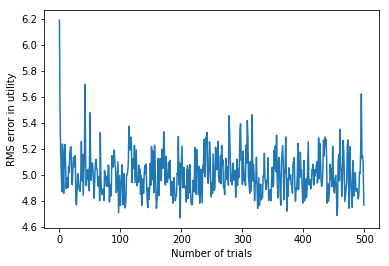

In [188]:
agent = PassiveDUEAgentM(policy, sequential_decision_environment)
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 50)

In [189]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):-5.093519063707184
(1, 2):-3.0227958586613837
(3, 2):0.0
(0, 0):-5.440460373224817
(3, 0):0.0
(3, 1):-1.0
(2, 1):-2.8271793972567387
(2, 0):0.0
(2, 2):-3.0249627843618634
(1, 0):-5.439397018220582
(0, 2):-5.0428110549435585


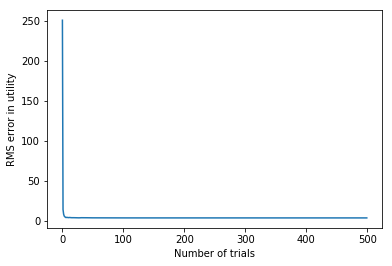

In [190]:
agent = PassiveADPAgentM(policy, sequential_decision_environment)
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 5)

In [191]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):-8.520656536464566
(1, 2):-8.415825644558586
(3, 2):0.0
(0, 0):-9.32530859168378
(3, 0):0.0
(3, 1):-1.0
(2, 1):-7.560169427841848
(2, 0):0.0
(2, 2):-8.365604912447981
(1, 0):-9.375278624797787
(0, 2):-8.470827405965792


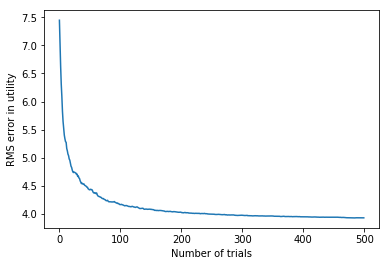

In [192]:
agent = PassiveTDAgentM(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 5)

In [193]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):-7.481222169653675
(1, 2):-7.446439430229006
(3, 2):0.0
(0, 0):-8.137711899092086
(3, 0):0.0
(3, 1):-1
(2, 1):-6.947626450212059
(2, 0):0.0
(2, 2):-7.417542455199257
(1, 0):-8.176024380123202
(0, 2):-7.455704520363911


In [194]:
actions = [north,east,south,west]
policy = {s: actions[np.random.choice(4)] for s in sequential_decision_environment.states}
policy[(3,1)] = None
policy[(3,2)] = None
print_table(sequential_decision_environment.to_arrows(policy))

<   <      v   .
v   None   <   .
>   v      ^   >


In [195]:
# Calculate the utilities of this policy using Bellman equations
U = {s: 0. for s in sequential_decision_environment.states}
U = policy_evaluation(policy,U,sequential_decision_environment,500) 
print('\n'.join([str(k)+':'+str(v) for k, v in U.items()]))

(0, 1):-3.6799772131491064
(1, 2):-4.12973112552605
(3, 2):1.0
(0, 0):-3.630002450808548
(3, 0):-1.4
(3, 1):-1.0
(2, 1):-3.225418717736044
(2, 0):-3.117710786100037
(2, 2):-2.93330808674144
(1, 0):-3.5737778189804725
(0, 2):-4.079761242773631


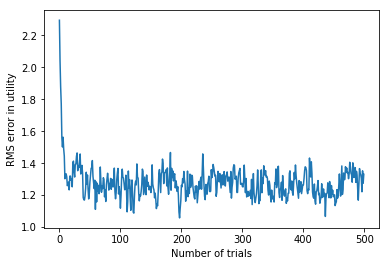

In [196]:
agent = PassiveDUEAgentM(policy, sequential_decision_environment)
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 50)

In [197]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):-2.635243501191195
(1, 2):-2.1677928001493525
(3, 2):1.0
(0, 0):-2.6048214392825804
(3, 0):-1.1118141529055796
(3, 1):-1.0
(2, 1):-1.3933405784636026
(2, 0):-1.5017510267115997
(2, 2):-0.9794235324317493
(1, 0):-2.4270544567956085
(0, 2):-1.9636184489824606


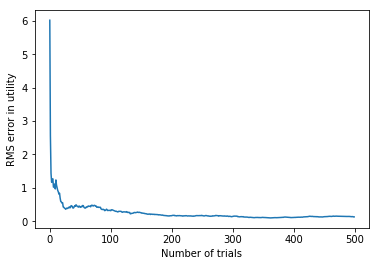

In [198]:
agent = PassiveADPAgentM(policy, sequential_decision_environment)
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 5)

In [199]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):-3.5794318444864563
(1, 2):-4.01842500089262
(3, 2):1.0
(0, 0):-3.529657338656942
(3, 0):-1.4045993031358885
(3, 1):-1.0
(2, 1):-3.090894264403733
(2, 0):-3.00665524550201
(2, 2):-2.771916869292028
(1, 0):-3.4724571561024375
(0, 2):-3.9660609128664843


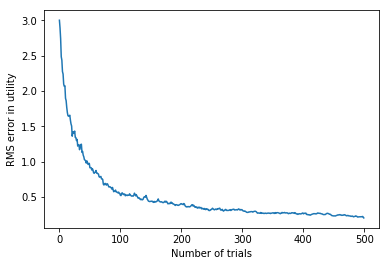

In [200]:
agent = PassiveTDAgentM(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
graph_utility_rms_policy_loss(agent, sequential_decision_environment, policy, 500, 5)

In [201]:
print('\n'.join([str(k)+':'+str(v) for k, v in agent.U.items()]))

(0, 1):-3.366454899990057
(1, 2):-3.836975716782819
(3, 2):1
(0, 0):-3.3263874043174853
(3, 0):-1.3188289826160269
(3, 1):-1
(2, 1):-3.049941460048196
(2, 0):-2.933063397658309
(2, 2):-2.9637143121019056
(1, 0):-3.2784865276314528
(0, 2):-3.800019960101071


In overall Adaptive Dynamic Programming seems to be converging fastest in terms of the number of iterations, but takes the longest time to calculate.

Let's try what effect a larger environment has on performance

In [202]:
def create_random_environment(n,m,pw=0.1,pt=0.05,pnt=0.05,r=-.04):
    '''
    Creates random grid world
    n - number of rows
    m- number of columns
    pt - probability of +1 terminal
    pnt - probability of -1 terminal
    r - reward in all the other states
    
    Probabilities have to sum up to lower or equal to 1
    '''
    assert pw+pt+pnt<=1
    grid = np.random.choice([None, 1, -1, r], size=(n,m), p=[pw,pt,pnt,1-(pw+pt+pnt)])
    reverse_grid = grid[::-1]
    terminals = list(zip(*np.where((reverse_grid==1) | (reverse_grid==-1))[::-1]))
    if not terminals:
        terminals+=[(np.random.randint(0,m),np.random.randint(0,n))]
        grid[terminals[0]]=1
    init = list(zip(*np.where(reverse_grid==r)))[0]
    return GridMDP(grid.tolist(), terminals=terminals, init=init)

In [204]:
# Create a random environment
env = create_random_environment(2**5,2**5)

In [206]:
# Find an optimal policy
policy = policy_iteration(env)

Check the agents' performance

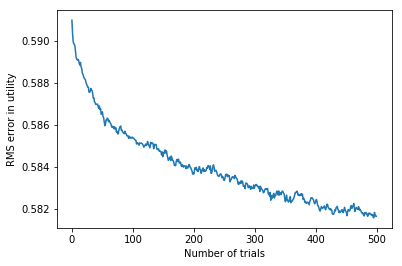

In [213]:
agent = PassiveDUEAgentM(policy, env)
graph_utility_rms_policy_loss(agent, env, policy, 500, 50)

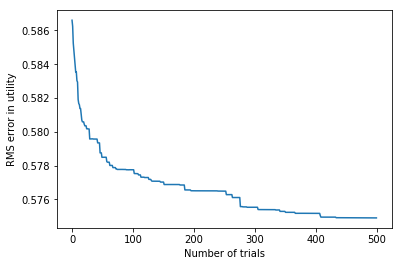

In [214]:
agent = PassiveADPAgentM(policy, env)
graph_utility_rms_policy_loss(agent, env, policy, 500, 5)

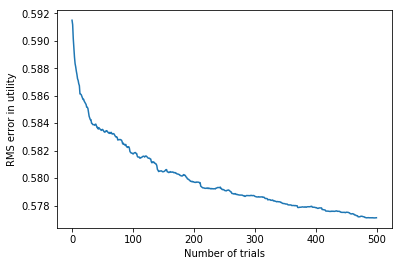

In [216]:
agent = PassiveTDAgentM(policy, env, alpha=lambda n: 60./(59+n))
graph_utility_rms_policy_loss(agent, env, policy, 500, 5)

Measure times for a single trial

833 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


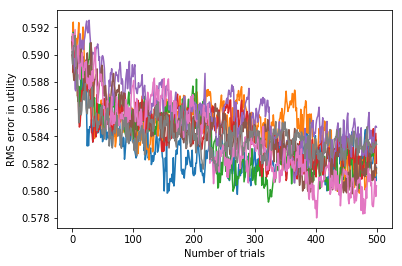

In [217]:
agent = PassiveDUEAgentM(policy, env)
%timeit graph_utility_rms_policy_loss(agent, env, policy, 500, 1)

3min 23s ± 2.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


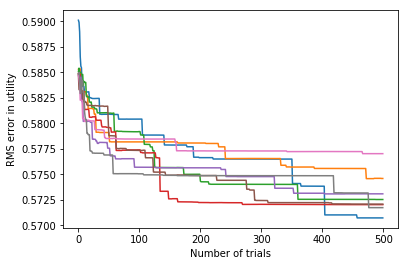

In [218]:
agent = PassiveADPAgentM(policy, env)
%timeit graph_utility_rms_policy_loss(agent, env, policy, 500, 1)

825 ms ± 5.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


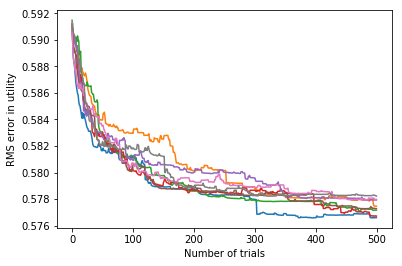

In [219]:
agent = PassiveTDAgentM(policy, env, alpha=lambda n: 60./(59+n))
%timeit graph_utility_rms_policy_loss(agent, env, policy, 500, 1)